# Data Augmentation Analysis
This notebook compares the original and augmented datasets for emotion classification.

### LLM-Based Synthetic Data Augmentation
A language model generated new journal entries for low support emotions and to add intensities to each entry. Synthetic samples were designed and manually reviewed to resemble ordinary, daily journal entries.

About 30% of the final dataset is synthetic, generated to supplement underrepresented emotions and intensities, and add a neutral baseline for the model to compare to. While this improves robustness, it may have introduced biases from the LLM into the dataset.

**Prompt example (repeated):**
```
You are a regular person writing a brief, spontaneous update in your personal journal at the end of an entirely ordinary day. Generate 40 journal entries that sound like a regular person writing at the end of an ordinary day. Entries should be conversational and reflect everyday life. Vary sentence structure and pronoun usage. Avoid poetic or clinical language. No commentary.
```

## Load Libraries

In [15]:
%pip install -q pandas seaborn

from pathlib import Path
import pandas as pd
import seaborn as sns

REPO_ROOT = Path().resolve().parent

Note: you may need to restart the kernel to use updated packages.


## Load Original and Augmented Datasets

In [16]:
# Load original Lemotif dataset
orig_url = (
    'https://raw.githubusercontent.com/xaliceli/lemotif/'
    'refs/heads/master/assets/data/lemotif-data-cleaned-flat.csv'
)
df_orig = pd.read_csv(orig_url)
print(f'Original dataset shape: {df_orig.shape}')

# Load augmented dataset (local)
aug_path = REPO_ROOT / 'ml' / 'datasets' / 'lemotif-data-augmented.csv'
df_aug = pd.read_csv(aug_path)
print(f'Augmented dataset shape: {df_aug.shape}')

Original dataset shape: (1473, 30)
Augmented dataset shape: (2120, 31)


## Compare Label Distributions

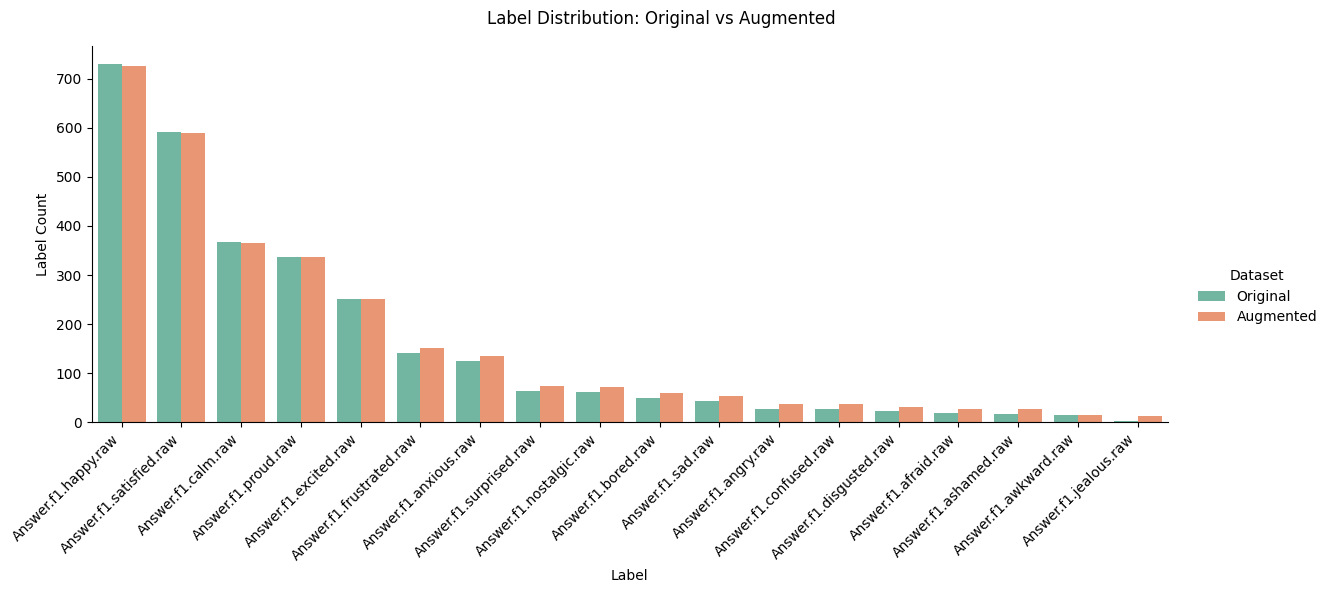

In [17]:
# Extract emotion columns
emotion_cols = [col for col in df_orig.columns if col.startswith('Answer.f1.')]
label_names = [col.replace('Answer.f1.', '').replace('.raw', '') for col in sorted(emotion_cols)]

# Count label occurrences in both datasets
orig_counts = df_orig[emotion_cols].astype(int).sum().sort_values(ascending=False)
aug_counts = df_aug[emotion_cols].astype(int).sum().sort_values(ascending=False)

# Prepare data in long format for seaborn
bar_df = pd.DataFrame({
    'Label': list(orig_counts.index) * 2,
    'Count': list(orig_counts.values) + list(aug_counts.values),
    'Dataset': ['Original'] * len(orig_counts) + ['Augmented'] * len(aug_counts)
})

g = sns.catplot(data=bar_df, x='Label', y='Count', hue='Dataset', kind='bar', palette='Set2', height=6, aspect=2.0)
g.set_xticklabels(rotation=45, ha='right')
g.set_axis_labels('Label', 'Label Count')
g.figure.suptitle('Label Distribution: Original vs Augmented')
g._legend.set_title('Dataset')
g.tight_layout()

## Example Augmented Samples
Let's look at a few examples of augmented data.

In [18]:
# Show a few original and augmented samples side by side
display_cols = ['Answer'] + emotion_cols[:3]  # Show first 3 emotions for brevity
print('Original:')
display(df_orig[display_cols].sample(3, random_state=1))
print('Augmented:')
display(df_aug[display_cols].sample(3, random_state=1))

Original:


,Answer,Answer.f1.afraid.raw,Answer.f1.angry.raw,Answer.f1.anxious.raw
1126,One of my kids is have a hard time with his he...,False,False,False
390,i had a good day that i hoped and prayed for. ...,False,False,False
824,My daughter is having marital problems and is ...,False,False,False


Augmented:


,Answer,Answer.f1.afraid.raw,Answer.f1.angry.raw,Answer.f1.anxious.raw
1208,I worked really hard at work yesterday. So muc...,False,False,False
447,I am in a computer architecture course. It is ...,False,False,False
1460,Went to bed and really needed it didn't get mu...,False,False,False


## Label Proportion Comparison
Compare the proportion of each label in both datasets.

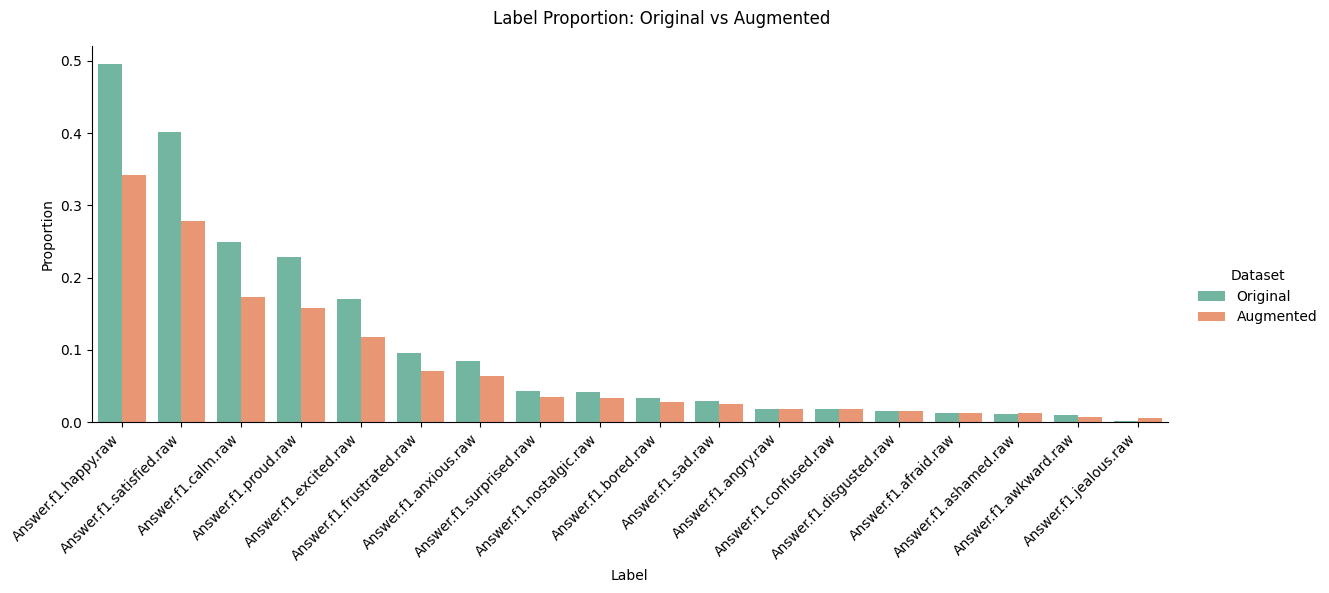

In [19]:
orig_props = orig_counts / len(df_orig)
aug_props = aug_counts / len(df_aug)

prop_df = pd.DataFrame({'Original': orig_props, 'Augmented': aug_props})
prop_df = prop_df.reset_index().melt(id_vars='index', var_name='Dataset', value_name='Proportion')
prop_df = prop_df.rename(columns={'index': 'Label'})

g = sns.catplot(data=prop_df, x='Label', y='Proportion', hue='Dataset', kind='bar', palette='Set2', height=6, aspect=2.0)
g.set_xticklabels(rotation=45, ha='right')
g.set_axis_labels('Label', 'Proportion')
g.figure.suptitle('Label Proportion: Original vs Augmented')
g.tight_layout()

### Intensity Augmentation

The `intensity` column was added to the augmented datasets to estimate the strength of emotions expressed in each entry. This was for the model to learn not just which emotions are present, but also how strongly they are felt, for more nuanced emotion analysis.

,Answer,intensity,Answer.f1.afraid.raw,Answer.f1.angry.raw,Answer.f1.anxious.raw
1079,God is very important in my daily life as He g...,0.45,False,False,False
405,I felt very obligated,0.18,False,False,False
1491,"During the evening, I needed a clear answer to...",0.67,False,False,False


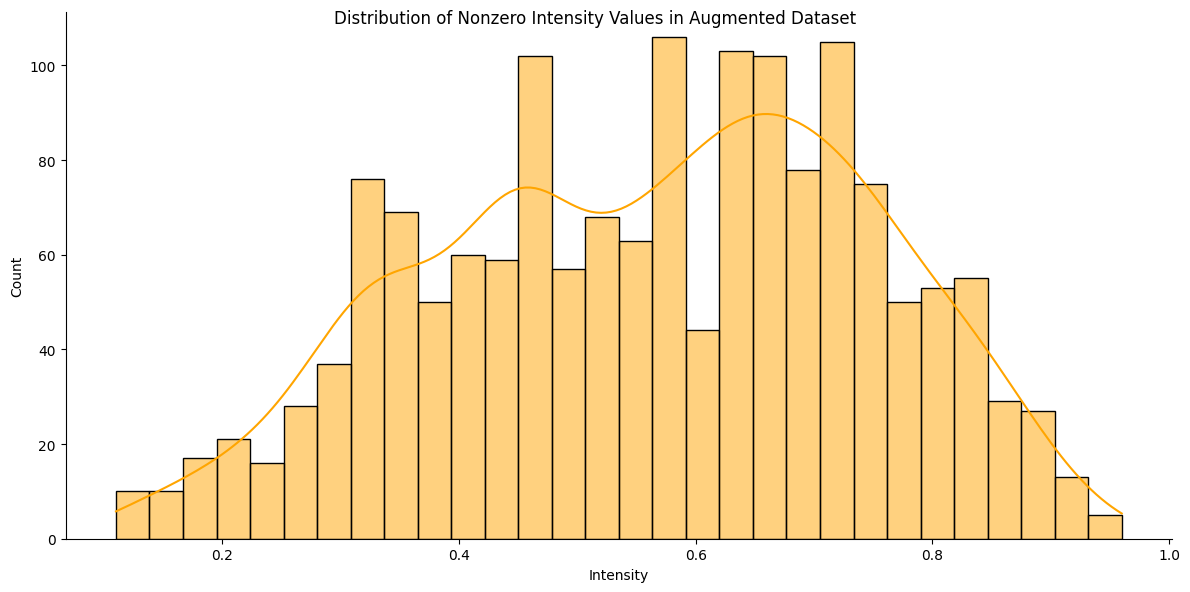

In [20]:
nonzero_intensity = df_aug[df_aug['intensity'] != 0.0]['intensity']
g = sns.displot(nonzero_intensity, bins=30, kde=True, color='orange', height=6, aspect=2.0)
g.set_axis_labels('Intensity', 'Count')
g.figure.suptitle('Distribution of Nonzero Intensity Values in Augmented Dataset')

nonneutral_rows = df_aug[(df_aug[emotion_cols].sum(axis=1) != 0) & (df_aug['intensity'] != 0.0)].sample(3, random_state=42)
display(nonneutral_rows[['Answer', 'intensity'] + emotion_cols[:3]])

## Summary

- Data augmentation increased the number of samples for rare emotions and helped balance the dataset.
- Adding neutral entries allows the model to better distinguish emotional from non-emotional text.